In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import skorch

from dataset import StockDataset
from denoising.autoencoder import CnnEncoder, CnnDecoder

from yahoo_fin_api import load_df

In [2]:
df = load_df('data/snp.csv')
df.head(), len(df)

(                  Open        High         Low       Close   Adj Close  \
 Date                                                                     
 1990-02-26  324.160004  328.670013  323.980011  328.670013  328.670013   
 1990-02-27  328.679993  331.940002  328.470001  330.260010  330.260010   
 1990-02-28  330.260010  333.480011  330.160004  331.890015  331.890015   
 1990-03-01  331.890015  334.399994  331.079987  332.739990  332.739990   
 1990-03-02  332.739990  335.540009  332.720001  335.540009  335.540009   
 
                Volume        Mean  
 Date                               
 1990-02-26  148900000  326.370010  
 1990-02-27  152590000  329.837502  
 1990-02-28  184400000  331.447510  
 1990-03-01  157930000  332.527496  
 1990-03-02  164330000  334.135002  ,
 8313)

In [3]:
data = torch.tensor(df['Mean'], dtype=torch.float32).unsqueeze(0)
data

tensor([[ 326.3700,  329.8375,  331.4475,  ..., 4024.3076, 3996.7876,
         4007.1025]])

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

In [5]:
input_space_dim = 10
num_epoch = 300

In [6]:
encoder = CnnEncoder(input_space_dim).to(device)
decoder = CnnDecoder(input_space_dim).to(device)
data = data.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = 1e-4, weight_decay=1e-5)

In [7]:
train_loss = []

encoder.train()
decoder.train()

for epoch in range(num_epoch):
    encoded_data = encoder(data)
    decoded_data = decoder(encoded_data)

    loss = criterion(decoded_data, data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.detach().cpu().numpy())

train_loss = pd.Series(train_loss).astype(np.float32)

<AxesSubplot: >

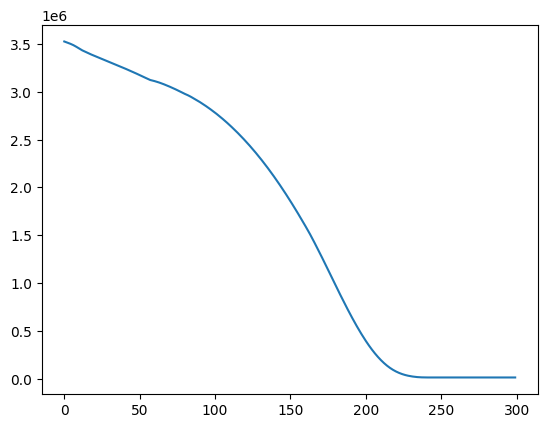

In [8]:
train_loss.plot.line()

<AxesSubplot: xlabel='Date'>

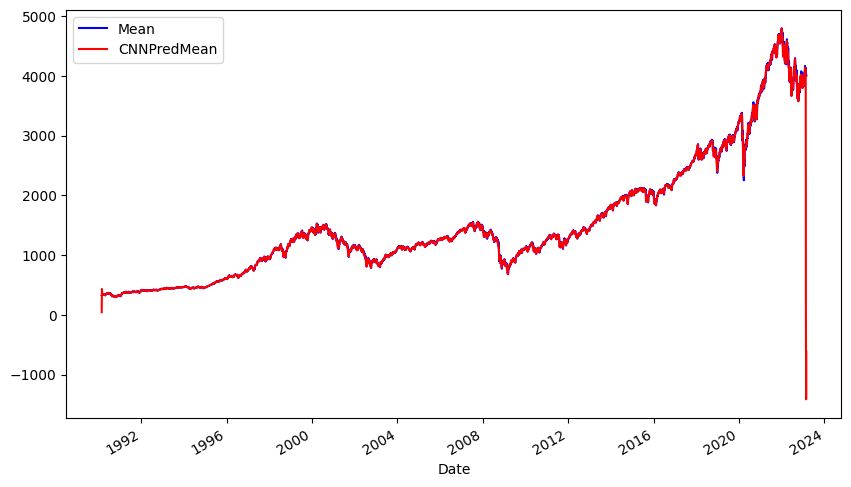

In [9]:
df['CNNPredMean'] = decoder(encoder(data)).detach().cpu().numpy().squeeze()
df[['Mean', 'CNNPredMean']].plot(color=['b', 'r'], figsize=(10, 6))